# Source reconstruction with lens mass fitting

Runs MCMC over lens model parameters, using SLIT to reconstruct the source at each iteration.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.LightModel.Profiles.starlets import Starlets

from slitronomy.Util.plot_util import nice_colorbar, log_cmap

from TDLMCpipeline.Util.plots import plot_convergence_by_walker
from TDLMCpipeline.Util.params import model_from_mcmc_sample

%matplotlib inline


subgrid_res_source = 2
use_threshold_mask = False
start_wayoff = False

n_burn = 0
n_run = 100
walker_ratio = 10
num_threads = 8

# uncomment parameters to fix those to truth
mass_fixed_list = [
    #'gamma',
    #'theta_E',
    #'e1', 'e2',
    #'center_x', 'center_y'
]

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

#background_rms = 0.05  # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


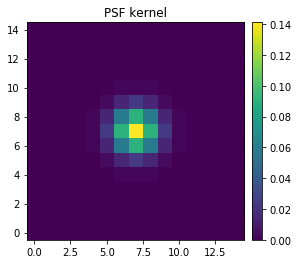

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    #'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
no_convolution = False
if no_convolution:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [5]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles from Galsim (COSMOS galaxy)
galsim_index = 1
snr = 500
galsim_data_path = ('data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
background_rms = data['background_rms']
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': galsim_delta_pix/3}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_truth = {
    'kwargs_lens': kwargs_lens, 
    'kwargs_source': kwargs_source, 
    'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
}

In [6]:
kwargs_numerics_sim = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                        kwargs_numerics=kwargs_numerics_sim)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['background_rms'] = background_rms
kwargs_data['noise_map']  = background_rms * np.ones_like(image_sim)
data_class.update_data(image_sim)

In [7]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix, 
                                                      subgrid_res=subgrid_res_source)

# get the light distribution in source plane on high resolution grid
source_sim_1d_hd = source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_1d_hd)

# get the light distribution in source plane at the image plane resolution
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

In [8]:
# get an automatic mask that includes the lensed source light
threshold_noise = 5
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold_noise * background_rms)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

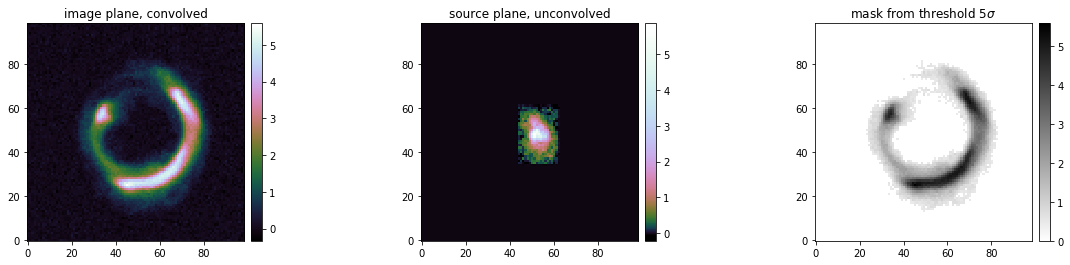

In [9]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()
fig.savefig("last_mock.png")

## Refinement step using starlets (pixel-based)

In [10]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

kwargs_data_joint = {
    'multi_band_list': [[kwargs_data, kwargs_psf, kwargs_numerics]],
    'multi_band_type': 'single-band-sparse',
}

kwargs_model = {
    'lens_model_list': lens_model_list, 
    'source_light_model_list': ['STARLETS'],
}

kwargs_lens_wayoff = [{'theta_E': 1.65, 'gamma': 1.8, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}]

if start_wayoff:
    kwargs_lens_init = kwargs_lens_wayoff
else:
    kwargs_lens_init = kwargs_truth['kwargs_lens']
kwargs_lens_sigma = [{'theta_E': 0.1, 'gamma': 0.05, 'center_x': 0.05, 'center_y': 0.05, 'e1': 0.05, 'e2': 0.05}]
kwargs_lens_lower = [{'theta_E': 1.6, 'gamma': 1.7, 'center_x': -0.5, 'center_y': -0.5, 'e1': -0.5, 'e2': -0.5}]
kwargs_lens_upper = [{'theta_E': 2, 'gamma': 2.2, 'center_x': 0.5, 'center_y': 0.5, 'e1': 0.5, 'e2': 0.5}]
kwargs_lens_fixed = [{}]
for i in range(len(kwargs_lens)):
    for fixed_name in mass_fixed_list:
        kwargs_lens_fixed[i][fixed_name] = kwargs_lens[i][fixed_name]
    
if len(kwargs_lens_fixed[0]) == len(kwargs_lens[0]) and len(kwargs_lens_fixed[1]) == len(kwargs_lens[1]):
    print("All parameters are fixed !")
    raise

kwargs_source_init  = [{'coeffs': 1}]  # starlet coeffs that are optimized for
kwargs_source_sigma = [{}]
kwargs_source_lower = [{}]
kwargs_source_upper = [{}]
kwargs_source_fixed = [
    {
        'n_scales': 6, 'n_pixels': num_pix**2 * subgrid_res_source**2, 
        'scale': 1, 'center_x': 0, 'center_y': 0,
    }
]

kwargs_special_init = {'delta_x_source_grid': 0, 'delta_y_source_grid': 0}
kwargs_special_sigma = {'delta_x_source_grid': delta_pix/4., 'delta_y_source_grid': delta_pix/4.}
kwargs_special_lower = {'delta_x_source_grid': -1, 'delta_y_source_grid': -1}
kwargs_special_upper = {'delta_x_source_grid': 1, 'delta_y_source_grid': 1}
kwargs_special_fixed = {}

kwargs_params = {
    'lens_model': [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
    'source_model': [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper],
    'special': [kwargs_special_init, kwargs_special_sigma, kwargs_special_fixed, kwargs_special_lower, kwargs_special_upper]
}

kwargs_init = {
    'kwargs_lens': kwargs_lens_init, 
    'kwargs_source': kwargs_source_init, 
    'kwargs_special': kwargs_special_init,
}

kwargs_constraints = {
    'solver_type': 'NONE',
    'image_plane_source_list': [False],
    
    'source_grid_offset': False,  # sample over offset of source plane grid 
}

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear', 
    
    'include_regridding_error': True,

    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': True,
    'fix_minimal_source_plane': True,  # if False, update source plane grid size when mass model changes (!)
    'min_num_pix_source': 130,

    'min_threshold': 3,
    'threshold_decrease_type': 'exponential',
    'num_iter_source': 15,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
    'thread_count': 1,
}

kwargs_likelihood = {
    'image_likelihood': True,
    'check_bounds': True,
    
    'kwargs_sparse_solver': kwargs_sparse_solver,
}
if use_threshold_mask:
    kwargs_likelihood['image_likelihood_mask_list'] = [image_mask.astype(bool)]

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params, verbose=True)
fitting_seq.param_class.print_setting()

The following model options are chosen:
Lens models: ['SPEMD']
Source models: ['STARLETS']
Lens light models: []
Point source models: []
The following parameters are being fixed:
Lens: [{}]
Source: [{'n_scales': 6, 'n_pixels': 39204, 'scale': 1, 'center_x': 0, 'center_y': 0, 'amp': 1}]
Lens light: []
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: []
Joint source with point source: []
Joint lens light with point source: []
Number of non-linear parameters being sampled:  6
Parameters being sampled:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0']
Number of linear parameters being solved for:  235224.0


In [11]:
fitting_list = [
    ['MCMC', {'n_burn': n_burn, 'n_run': n_run, 'walkerRatio': walker_ratio, 'sampler_type': 'EMCEE',
              'sigma_scale': 1, 'threadCount': num_threads}],
]

chain_list = fitting_seq.fit_sequence(fitting_list)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Forked/emcee-3.0.2_mod/src/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [18:00<00:00,  9.86s/it]

Computing the MCMC...
Number of walkers =  60
Burn-in iterations:  0
Sampling iterations: 100
1087.4967563152313 time taken for MCMC sampling


(num samples, num params) : (6000, 6)


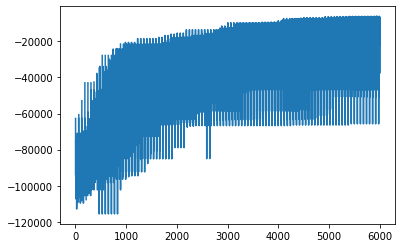

In [12]:
# get MCMC chains
sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[-1]
print("(num samples, num params) :", samples_mcmc.shape)

walker_ratio = fitting_list[0][1]['walkerRatio']
num_param_nonlinear = len(param_mcmc)

plt.plot(dist_mcmc)
plt.show()

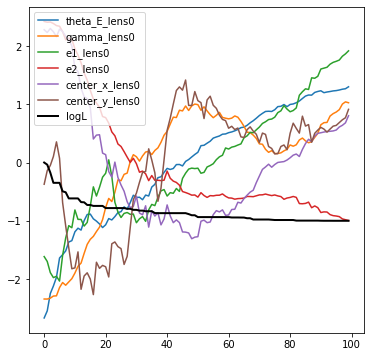

In [13]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i, num_average=walker_ratio*num_param_nonlinear)
plt.show()

In [14]:
# best fit from MCMC
kwargs_result = fitting_seq.best_fit()
print(kwargs_result)

{'kwargs_lens': [{'theta_E': 1.8035900887975753, 'gamma': 2.0457376585479192, 'e1': 0.11010847752062691, 'e2': -0.22387045800947228, 'center_x': 0.0009658603642589053, 'center_y': -0.008611944678936622}], 'kwargs_source': [{'amp': 1, 'n_scales': 6, 'n_pixels': 39204, 'scale': 1, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


initial [1.65, 1.8, 0, 0, 0, 0]
best logL [1.8035900887975753, 2.0457376585479192, 0.11010847752062691, -0.22387045800947228, 0.0009658603642589053, -0.008611944678936622]
truth [1.8, 2, 0.1, -0.2, 0, 0]


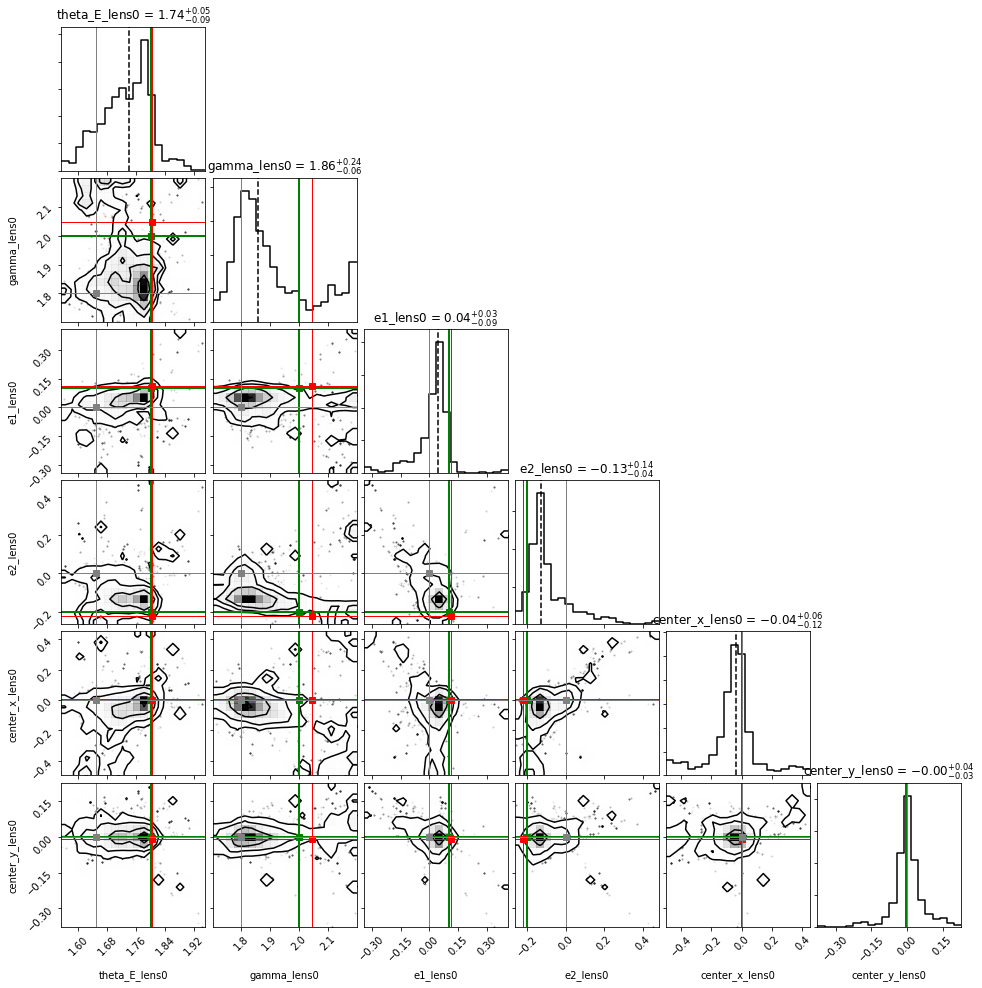

In [15]:
def corner_add_values_indic(fig, values, color='green', linewidth=1):
    # Extract the axes
    ndim = len(values)
    axes = np.array(fig.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(values[i], color=color, linewidth=linewidth)
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(values[xi], color=color, linewidth=linewidth)
            ax.axhline(values[yi], color=color, linewidth=linewidth)
            ax.plot(values[xi], values[yi], color=color, marker='s')

# get init/best/true parameter values as list
init_params = fitting_seq.param_class.kwargs2args(**kwargs_init)
print("initial", init_params)
bestlogL_params = fitting_seq.param_class.kwargs2args(**kwargs_result)
print("best logL", bestlogL_params)
truth_params = fitting_seq.param_class.kwargs2args(**kwargs_truth)
print("truth", truth_params)

fig = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True, quantiles=[0.5], smooth=0.6, smooth1d=0.6)
corner_add_values_indic(fig, truth_params, color='green', linewidth=2)
corner_add_values_indic(fig, bestlogL_params, color='red', linewidth=1)
corner_add_values_indic(fig, init_params, color='gray', linewidth=1)
plt.show()
fig.savefig("last_corner.png")

theta_E_lens0 1.7895 +/- 0.0486
gamma_lens0 1.8906 +/- 0.1420
e1_lens0 0.0699 +/- 0.0346
e2_lens0 -0.1517 +/- 0.0285
center_x_lens0 -0.0094 +/- 0.0634
center_y_lens0 -0.0023 +/- 0.0167


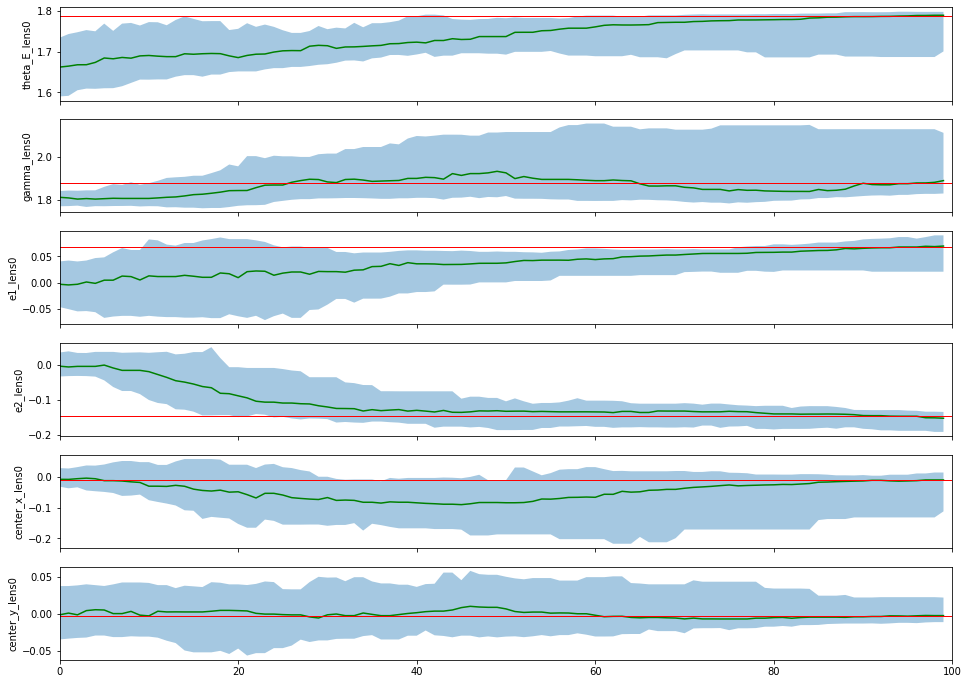

In [16]:
# convergence by walkers
[fig] = plot_convergence_by_walker(samples_mcmc, param_mcmc, walker_ratio, verbose=True)
plt.show()
fig.savefig("last_mcmc_conv.png")

### Update Starlets parameters from best fit

In [17]:
multi_band_list = kwargs_data_joint['multi_band_list']
multi_band_type = kwargs_data_joint['multi_band_type']
likelihood_mask_list = kwargs_likelihood.get('image_likelihood_mask_list', None)
kwargs_sparse_solver = kwargs_likelihood['kwargs_sparse_solver']
im_sim = class_creator.create_im_sim(multi_band_list, multi_band_type, kwargs_model,
                                     likelihood_mask_list=likelihood_mask_list,
                                     kwargs_sparse_solver=kwargs_sparse_solver)

# compute starlets "sparse" parameters and update corresponding kwargs
model, model_error, _, _ = im_sim.image_linear_solve(**kwargs_result)
print(kwargs_result, kwargs_result['kwargs_source'][0]['amp'].shape)

{'kwargs_lens': [{'theta_E': 1.8035900887975753, 'gamma': 2.0457376585479192, 'e1': 0.11010847752062691, 'e2': -0.22387045800947228, 'center_x': 0.0009658603642589053, 'center_y': -0.008611944678936622}], 'kwargs_source': [{'amp': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.57953618e-05, 1.39639742e-05, 1.23023747e-05]), 'n_scales': 6, 'n_pixels': 39204, 'scale': 0.039999999999999994, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []} (235224,)


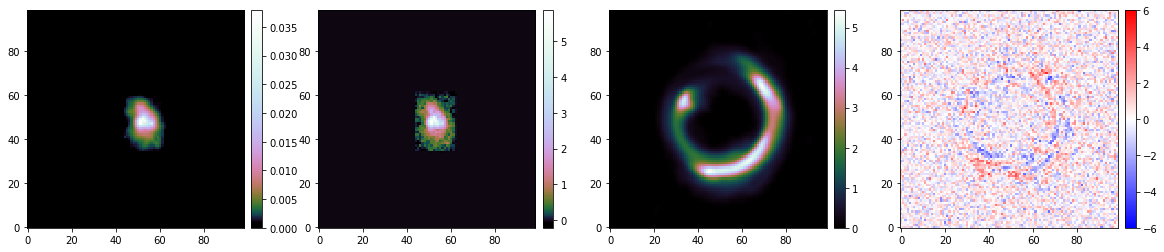

In [18]:
reduced_residuals  = im_sim.reduced_residuals(model)
source = im_sim.source_surface_brightness(kwargs_result['kwargs_source'], kwargs_lens=None, 
                                          unconvolved=True, de_lensed=True)

kwargs_source_result = kwargs_result['kwargs_source'][0]
starlets_class = Starlets(second_gen=False)
x_grid_hd, y_grid_hd = lenstro_util.make_grid(numPix=np.sqrt(kwargs_source_result['n_pixels']), 
                                              deltapix=kwargs_source_result['scale'])
source_hd = lenstro_util.array2image(starlets_class.function(x_grid_hd, y_grid_hd, 
                                                             **kwargs_source_result))

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
ax = axes[0]
im = ax.imshow(source, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)
ax = axes[1]
im = ax.imshow(source_sim, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)
ax = axes[2]
im = ax.imshow(model, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[3]
im = ax.imshow(reduced_residuals, origin='lower', cmap='bwr', vmin=-6, vmax=6)
nice_colorbar(im)
#plt.show()
fig.savefig("last_starlets_recon.png")